Training classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Remaining classes: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
Files already downloaded and verified
Files already downloaded and verified
Classi presenti nel dataset di test: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
Classi presenti nel dataset di training: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
No checkpoint found at '.

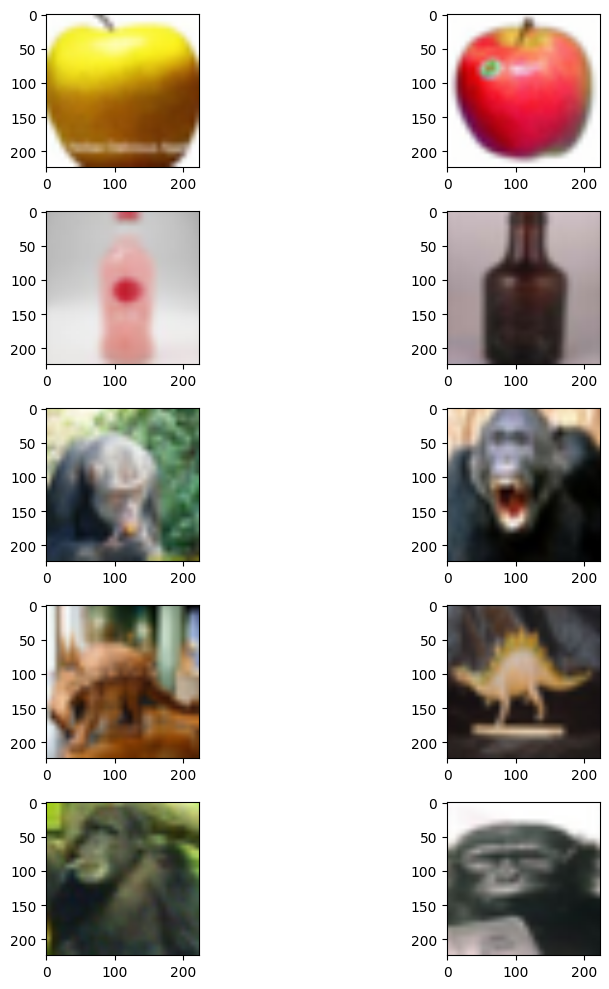

Different Class Pairs:


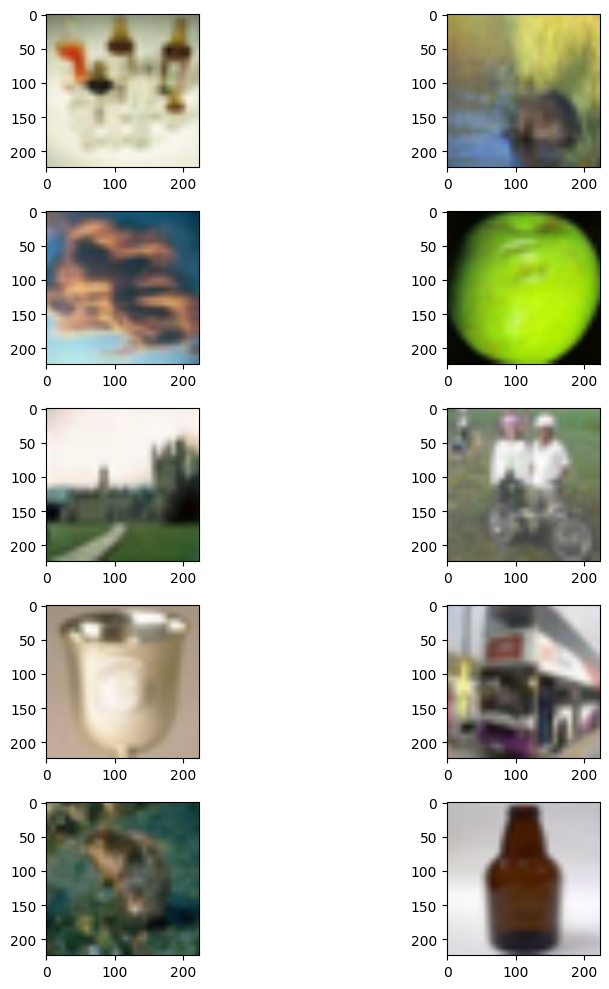

Train Epoch: 1 [0/15000 (0%)]	Loss: 0.697415
Train Epoch: 1 [640/15000 (4%)]	Loss: 0.765799
Train Epoch: 1 [1280/15000 (9%)]	Loss: 0.679864
Train Epoch: 1 [1920/15000 (13%)]	Loss: 0.693165
Train Epoch: 1 [2560/15000 (17%)]	Loss: 0.703075
Train Epoch: 1 [3200/15000 (21%)]	Loss: 0.678049
Train Epoch: 1 [3840/15000 (26%)]	Loss: 0.681199
Train Epoch: 1 [4480/15000 (30%)]	Loss: 0.684559
Train Epoch: 1 [5120/15000 (34%)]	Loss: 0.692538
Train Epoch: 1 [5760/15000 (38%)]	Loss: 0.690668
Train Epoch: 1 [6400/15000 (43%)]	Loss: 0.689392
Checkpoint saved at epoch 1, batch 100
Train Epoch: 1 [7040/15000 (47%)]	Loss: 0.686907
Train Epoch: 1 [7680/15000 (51%)]	Loss: 0.691976
Train Epoch: 1 [8320/15000 (55%)]	Loss: 0.697304
Train Epoch: 1 [8960/15000 (60%)]	Loss: 0.695329
Train Epoch: 1 [9600/15000 (64%)]	Loss: 0.698925
Train Epoch: 1 [10240/15000 (68%)]	Loss: 0.697375
Train Epoch: 1 [10880/15000 (72%)]	Loss: 0.694341
Train Epoch: 1 [11520/15000 (77%)]	Loss: 0.696228
Train Epoch: 1 [12160/15000 (81%)]

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import numpy as np
import random
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models
from PIL import Image
import os

# Check if CUDA is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the loss function
loss_fn = nn.BCELoss()

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for ResNet
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
])

args = {
    'batch_size': 64,
    'test_batch_size': 1000,
    'epochs': 10,
    'lr': 0.001,
    'gamma': 0.7,
    'no_cuda': False,
    'no_mps': False,
    'dry_run': False,
    'seed': 1,
    'log_interval': 10,
    'save_model': True,
    'save_interval_batches': 100,
    'seed': 42,
    'checkpoint_path': '../checkpoints/checkpoint.pt'
}

# Set random seed for reproducibility
torch.manual_seed(args['seed'])

class SiameseCIFAR100(Dataset):
    def __init__(self, root, train, download=False, transform=None, classes_to_include=None):
        super(SiameseCIFAR100, self).__init__()

        # Get CIFAR-100 dataset
        self.dataset = datasets.CIFAR100(root, train=train, download=download)
        
        self.transform = transform
        self.classes_to_include = classes_to_include if classes_to_include else list(range(100))

        # Filter dataset for the selected classes
        self.data, self.targets = self.filter_dataset_by_classes()

        self.group_examples()

    def filter_dataset_by_classes(self):
        data = []
        targets = []
        for idx, target in enumerate(self.dataset.targets):
            if target in self.classes_to_include:
                data.append(self.dataset.data[idx])
                targets.append(target)
        return np.array(data), np.array(targets)
    
    def group_examples(self):
        np_arr = np.array(self.targets)
        self.grouped_examples = {i: np.where(np_arr == i)[0] for i in self.classes_to_include}
    
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, index):
        selected_class = random.choice(self.classes_to_include)
        random_index_1 = random.choice(self.grouped_examples[selected_class])
        index_1 = random_index_1
        image_1 = self.data[index_1]

        if index % 2 == 0:
            random_index_2 = random.choice(self.grouped_examples[selected_class])
            while random_index_2 == random_index_1:
                random_index_2 = random.choice(self.grouped_examples[selected_class])
            index_2 = random_index_2
            image_2 = self.data[index_2]
            target = torch.tensor(1, dtype=torch.float)
        else:
            other_selected_class = random.choice(self.classes_to_include)
            while other_selected_class == selected_class:
                other_selected_class = random.choice(self.classes_to_include)
            random_index_2 = random.choice(self.grouped_examples[other_selected_class])
            index_2 = random_index_2
            image_2 = self.data[index_2]
            target = torch.tensor(0, dtype=torch.float)

        image_1 = Image.fromarray(image_1)  # Convert to PIL Image
        image_2 = Image.fromarray(image_2)  # Convert to PIL Image

        if self.transform:
            image_1 = self.transform(image_1)
            image_2 = self.transform(image_2)

        return image_1, image_2, target

class SiameseResNet(nn.Module):
    def __init__(self):
        super(SiameseResNet, self).__init__()
        # Load pre-trained ResNet18
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        
        # Remove the original fully connected layer and add a new one
        self.resnet.fc = nn.Identity()  # Remove the original fc layer
        
        # Define a new fully connected layer for the Siamese network
        self.fc = nn.Sequential(
            nn.Linear(512 * 2, 256),  # 512 features for each image, and 2 images
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
        )

    def forward_once(self, x):
        return self.resnet(x)

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output = self.fc(torch.cat((output1, output2), dim=1))
        output = torch.sigmoid(output)  # Using contrastive loss
        return output
    
# Function definitions for training, testing, saving, loading checkpoints and creating support and query sets
def train(model, device, train_loader, optimizer, epoch, start_batch_idx=0):
    model.train()
    train_loss = 0
    for batch_idx, (data1, data2, target) in enumerate(train_loader, start=start_batch_idx):
        # Assicurati che l'indice del batch non superi la dimensione del dataset
        if batch_idx >= len(train_loader):
            break
        
        data1, data2, target = data1.to(device), data2.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data1, data2)
        loss = loss_fn(output, target.unsqueeze(1))
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        if batch_idx % args['log_interval'] == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data1)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
        
        if args['save_model'] and batch_idx % args['save_interval_batches'] == 0 and batch_idx != start_batch_idx:
            save_checkpoint(model, optimizer, epoch, batch_idx, loss.item(), args['checkpoint_path'])
    
    avg_train_loss = train_loss / len(train_loader)
    return avg_train_loss



def test(model, device, support_set, query_set):
    model.eval()
    correct = 0
    test_loss = 0
    with torch.no_grad():
        for query, true_class in query_set:
            query = query.unsqueeze(0).to(device)
            similarities = []
            for support_class, support_image in support_set.items():
                support_image = support_image.unsqueeze(0).to(device)
                output = model(query, support_image)
                similarities.append((output.item(), support_class))
            predicted_class = max(similarities, key=lambda x: x[0])[1]
            if predicted_class == true_class:
                correct += 1
            # Ensure the target tensor is correctly formatted
            target = torch.tensor([[1.0]] if predicted_class == true_class else [[0.0]], dtype=torch.float, device=device)
            test_loss += loss_fn(output, target).item()

    accuracy = correct / len(query_set)
    avg_test_loss = test_loss / len(query_set)
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Loss: {avg_test_loss:.6f}')
    return accuracy, avg_test_loss


def create_support_and_query_sets(dataset, remaining_classes):
    support_set = {}
    query_set = []
    for cls in remaining_classes:
        indices = dataset.grouped_examples[cls]
        support_idx = random.choice(indices)
        support_set[cls] = dataset[support_idx][0]  # only need the first image for support set
        for idx in indices:
            if idx != support_idx:
                query_set.append((dataset[idx][0], cls))  # add image and its class
    return support_set, query_set

def save_checkpoint(model, optimizer, epoch, batch_idx, loss, filepath):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'batch_idx': batch_idx,
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved at epoch {epoch}, batch {batch_idx}")

def load_checkpoint(model, optimizer, filepath):
    if os.path.isfile(filepath):
        print(f"Loading checkpoint '{filepath}'")
        checkpoint = torch.load(filepath)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        batch_idx = checkpoint['batch_idx']
        loss = checkpoint['loss']
        print(f"Loaded checkpoint at epoch {epoch}, batch {batch_idx} with loss {loss:.6f}")
        return epoch, batch_idx
    else:
        print(f"No checkpoint found at '{filepath}'")
        return None, None

def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    tensor = tensor * std + mean
    return torch.clamp(tensor, 0, 1)

def display_image_pairs(dataset, num_pairs=5):
    """Display pairs of images, both from the same class and different classes."""
    same_class_pairs = []
    diff_class_pairs = []   
    for i in range(len(dataset)):
        img1, img2, label = dataset[i]  # unpacking three values
        if label == 1 and len(same_class_pairs) < num_pairs:
            same_class_pairs.append((img1, img2))
        elif label == 0 and len(diff_class_pairs) < num_pairs:
            diff_class_pairs.append((img1, img2))
        
        if len(same_class_pairs) >= num_pairs and len(diff_class_pairs) >= num_pairs:
            break

    # Plot same-class pairs
    print("Same Class Pairs:")
    plt.figure(figsize=(10, 2 * num_pairs))
    for i, (img1, img2) in enumerate(same_class_pairs):
        img1 = denormalize(img1, (0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
        img2 = denormalize(img2, (0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
        plt.subplot(num_pairs, 2, 2 * i + 1)
        plt.imshow(img1.permute(1, 2, 0).numpy())
        plt.subplot(num_pairs, 2, 2 * i + 2)
        plt.imshow(img2.permute(1, 2, 0).numpy())
    plt.tight_layout()
    plt.show()

    # Plot different-class pairs
    print("Different Class Pairs:")
    plt.figure(figsize=(10, 2 * num_pairs))
    for i, (img1, img2) in enumerate(diff_class_pairs):
        img1 = denormalize(img1, (0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
        img2 = denormalize(img2, (0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
        plt.subplot(num_pairs, 2, 2 * i + 1)
        plt.imshow(img1.permute(1, 2, 0).numpy())
        plt.subplot(num_pairs, 2, 2 * i + 2)
        plt.imshow(img2.permute(1, 2, 0).numpy())
    plt.tight_layout()
    plt.show()

# Load custom Siamese CIFAR-100 dataset
# Subset of classes for training
train_classes = list(range(30))
remaining_classes = list(range(30, 100))
print(f"Training classes: {train_classes}")
print(f"Remaining classes: {remaining_classes}")

# Initialize lists to store training and testing results
train_losses = []
test_accuracies = []
test_losses = []

# Load datasets with specified classes
train_dataset = SiameseCIFAR100(root='./data', train=True, download=True, transform=transform, classes_to_include=train_classes)
test_dataset = SiameseCIFAR100(root='./data', train=False, download=True, transform=transform, classes_to_include=remaining_classes)
train_loader = DataLoader(train_dataset, batch_size=args['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=args['test_batch_size'], shuffle=False)
# Verifica delle classi nel dataset di test
test_classes = list(test_dataset.grouped_examples.keys())
print(f"Classi presenti nel dataset di test: {test_classes}")
train_classes = list(train_dataset.grouped_examples.keys())
print(f"Classi presenti nel dataset di training: {train_classes}")

# Initialize the model, optimizer, and start the training process
model = SiameseResNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=args['lr'])

# Load checkpoint if available
start_epoch, start_batch_idx = load_checkpoint(model, optimizer, args['checkpoint_path'])
if start_epoch is None:
    start_epoch = 1
    start_batch_idx = 0

# Display a few pairs of images to see what the data looks like
display_image_pairs(train_dataset, num_pairs=5)

# Create support and query sets for evaluation
support_set, query_set = create_support_and_query_sets(test_dataset, remaining_classes)

# Training and testing loop
for epoch in range(start_epoch, args['epochs'] + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch, start_batch_idx)
    train_losses.append(train_loss)
    start_batch_idx = 0  # reset batch index after the first epoch
    
    # Test the model
    test_accuracy, test_loss = test(model, device, support_set, query_set)
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)

# Plot training loss and testing accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, args['epochs'] + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, args['epochs'] + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, args['epochs'] + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Save the model if needed
if args['save_model']:
    torch.save(model.state_dict(), "./siamese_network.pt")
